# Introdução a Física Estatística e Computacional
## Teoria dos jogos - jogos evolucionários
### Luís Felipe Ramos Ferreira - 2019022553

In [276]:
import numpy as np
import numpy.typing as npt
import gif
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import time
import numba
import warnings

In [277]:
# constants

DEFECTOR: np.int8 = 0
COOPERATOR: np.int8 = 1

L: np.int32 = 10
GRID_SIZE: np.int32 = L * L

RED = 1, 0, 0
GREEN = 0, 1, 0

COLORS: list[str] = [RED, GREEN]

In [278]:
@numba.jit(nopython=True)
def get_neighbours(grid_size: np.int64) -> npt.NDArray[np.int16]:
    L: np.int16 = int(np.sqrt(grid_size))
    neighbours = np.zeros((grid_size, 4), dtype=np.int16)
    for k in np.arange(grid_size):
        neighbours[k, 0] = k + 1
        if (k + 1) % L == 0:
            neighbours[k, 0] = k + 1 - L
        neighbours[k, 1] = k + L
        if k > (grid_size - L - 1):
            neighbours[k, 1] = k + L - grid_size
        neighbours[k, 2] = k - 1
        if k % L == 0:
            neighbours[k, 2] = k + L - 1
        neighbours[k, 3] = k - L
        if k < L:
            neighbours[k, 3] = k + grid_size - L
    return neighbours

In [279]:
@gif.frame
def draw_grid(grid: npt.NDArray[np.int8]) -> None:
    cmap = colors.ListedColormap(colors=COLORS)
    bounds = [0, 1]
    grid = np.reshape(grid, newshape=(int(np.sqrt(grid.size)), int(np.sqrt(grid.size))))
    plt.figure(figsize=(8, 4))
    plt.title(f"Problema dos Prisioneiros")
    plt.xlabel(f"{grid.shape} grid")
    plt.xticks(np.arange(grid.shape[0] + 1), labels=[])
    plt.yticks(np.arange(grid.shape[0] + 1), labels=[])
    patches = [
        mpatches.Patch(color=COLORS[i], label=f"{'Cooperator' if i else 'Defector'}")
        for i in np.arange(2)
    ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.imshow(
        grid,
        cmap=cmap,
        origin="lower",
        extent=(0, grid.shape[0], 0, grid.shape[0]),
        vmin=0,
        vmax=2,
    )


def create_gif(frames: npt.NDArray[np.int8], path: str) -> None:
    gif.save(frames, path, duration=40)

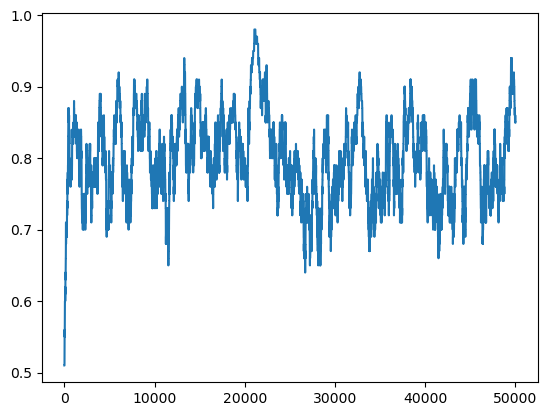

array([[1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 0]])

In [285]:
def func(b: np.float32 = 0, K: np.float32 = 0.02, gif: bool = False) -> None:
    neighbours: npt.NDArray[np.int32] = get_neighbours(grid_size=GRID_SIZE)
    gain_matrix: npt.NDArray[np.int8] = np.array([[1, 0], [b, 0]])
    grid: npt.NDArray[np.int8] = np.random.choice([DEFECTOR, COOPERATOR], size=GRID_SIZE)
    reshaped_grid: npt.NDArray[np.int8] = np.reshape(grid, newshape=(int(np.sqrt(GRID_SIZE)), int(np.sqrt(GRID_SIZE))))
    frames: list = []
    density_of_cooperators: np.flot32 = np.count_nonzero(grid)/ grid.size
    densities = [density_of_cooperators]
    for _ in np.arange(50000):

        if gif:
            frames.append(draw_grid(grid=grid))

        # define random individual and it's gain
        random_individual: np.int32 = np.random.randint(low=0, high=GRID_SIZE)
        nature: np.int8 = grid[random_individual]
        neighbours_nature: npt.NDArray[np.int8] = np.append(grid[neighbours[random_individual]], nature)
        total_gain: np.float32 = np.sum(gain_matrix[nature, [neighbours_nature]])

        # chose random neighbours and get it's gain
        random_individual_neighbour: np.int8 = np.random.choice(neighbours[random_individual], size=1)
        # ficar de olho nessa repeticao de nomes de variáveis
        nature = grid[random_individual_neighbour]
        neighbours_nature = np.append(grid[neighbours[random_individual_neighbour]], nature)
        total_neighbour_gain: np.float32 = np.sum(gain_matrix[nature, [neighbours_nature]])

        W: np.float32 = 1 / (1 + np.exp((total_gain - total_neighbour_gain) / K))

        if np.random.rand() < W:
            if grid[random_individual] != grid[random_individual_neighbour]:
                if grid[random_individual] == COOPERATOR:
                    density_of_cooperators -= 1 / grid.size
                else:
                    density_of_cooperators += 1 / grid.size
            grid[random_individual] = grid[random_individual_neighbour]
        densities.append(density_of_cooperators)
    plt.plot(densities)
    plt.show()
    reshaped_grid: npt.NDArray[np.int8] = np.reshape(grid, newshape=(int(np.sqrt(GRID_SIZE)), int(np.sqrt(GRID_SIZE))))
    if gif:
        create_gif(frames, path=f"example.gif")
    return reshaped_grid

func(b=1.9)

